# 01 – Data Fetching Demo

This notebook demonstrates how to use our `data/fetch_data.py` utility to load market prices
and visualize them. We will:

1. Fetch data for a small set of tickers
2. Inspect the raw inputs
3. Plot the price series


In [13]:
# Imports
import os, sys, numpy as np, matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams["font.family"] = "Times New Roman" # Set font to Times New Roman
# Add the repo root (one level up from notebooks) to Python path
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(repo_root)


from data.fetch_data import load_prices


### Step 1: Choose tickers and time window


In [14]:
### Step 1: Choose tickers and time window
tickers = ["META", "AAPL", "MSFT", "GOOGL", "AMZN"]
start_date = "2024-01-01"
end_date = "2024-12-31"


### Step 2: Fetch prices
We use the `load_prices` function from our package.  
This returns a **wide DataFrame**: rows = dates, columns = tickers.


In [15]:
prices = load_prices(tickers, start=start_date, end=end_date)
print("Shape:", prices.shape)
print("Columns:", prices.columns.tolist())
print(prices.head())


Shape: (251, 5)
Columns: ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT']
Ticker         AAPL     AMZN    GOOGL     META     MSFT
Date                                                   
2024-01-02 184.0815 149.9300 137.3463 344.4006 366.1055
2024-01-03 182.7032 148.4700 138.0918 342.5905 365.8390
2024-01-04 180.3828 144.5700 135.5769 345.2260 363.2132
2024-01-05 179.6589 145.2400 134.9208 350.0297 363.0256
2024-01-08 184.0022 149.1000 138.0123 356.7031 369.8765


### Step 3: Plot price series


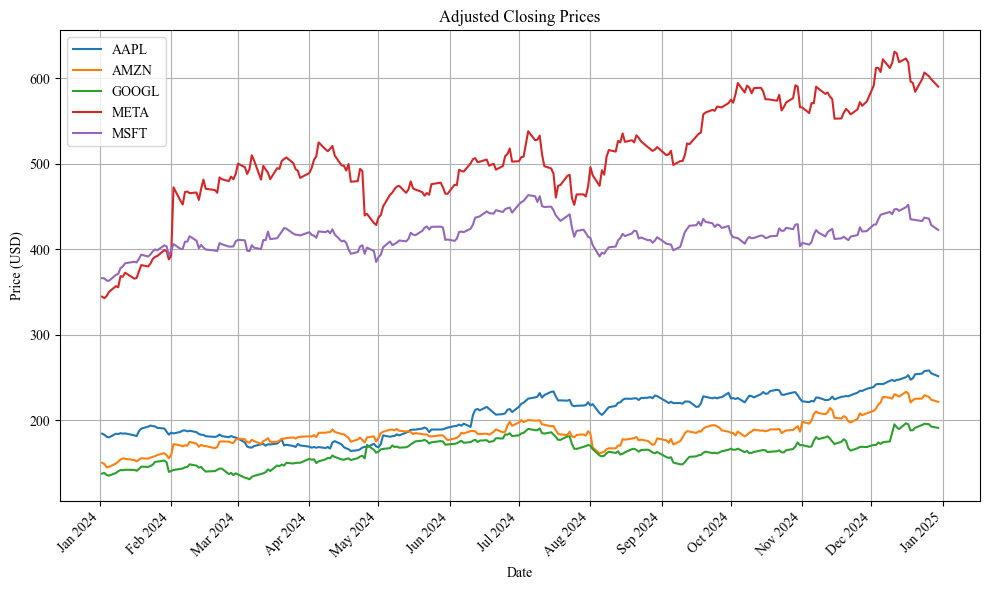

In [16]:

plt.figure(figsize=(10, 6))
ax = plt.gca()

prices.plot(ax=ax)

# Format x-axis by month
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # tick every month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # e.g. "Jan 2022"

plt.title("Adjusted Closing Prices")
plt.ylabel("Price (USD)")
plt.xlabel("Date")
plt.grid(True)
plt.legend(loc="upper left")

plt.xticks(rotation=45)  # rotate labels for readability
plt.tight_layout()
plt.show()


### Step 4: Plot normalized (rebased) prices
Often we normalize all tickers to start at 1.0 to compare growth.


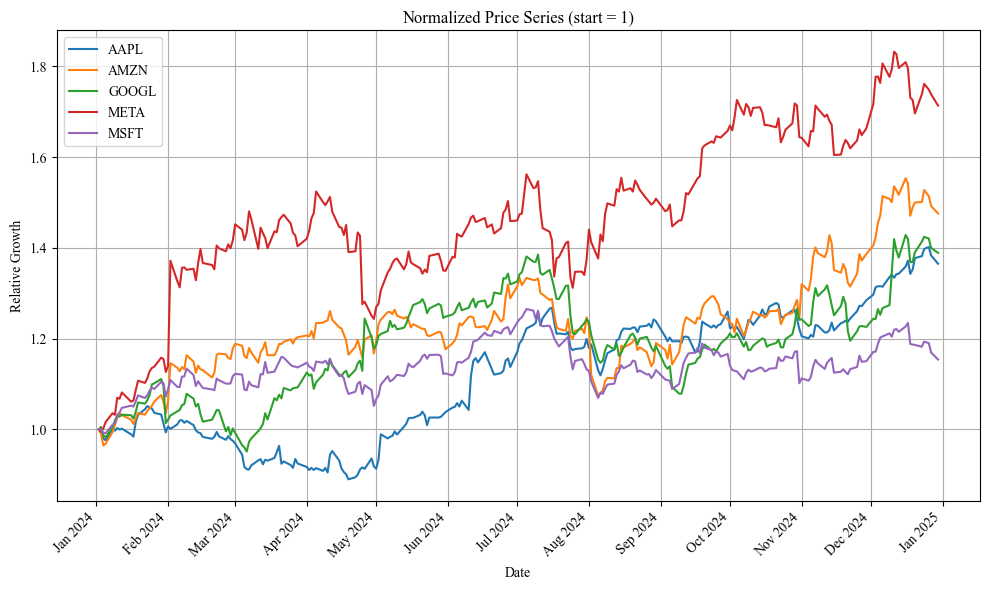

In [17]:
normalized = prices / prices.iloc[0]
plt.figure(figsize=(10, 6))
ax = plt.gca()

normalized.plot(ax=ax)

# Format x-axis to show months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))   # tick every month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))   # e.g. "Jan 2022"

plt.title("Normalized Price Series (start = 1)")
plt.ylabel("Relative Growth")
plt.xlabel("Date")
plt.grid(True)
plt.legend(loc="upper left")

plt.xticks(rotation=45)  # rotate labels
plt.tight_layout()
plt.show()

## How We Calculate Weights and Portfolio Value

### 1. Calculating Weights
- For each stock (ticker), we obtain the **free float**:  
  the number of shares available for trading (excluding insider holdings, restricted shares, etc.).
- We then compute the **total free float** across all stocks in the portfolio:
  $
  \text{Total Free Float} = \sum_i \text{Free Float}(i)
  $
- The **weight** of each stock is its share of the total free float:
  $
  w_i = \frac{\text{Free Float}(i)}{\text{Total Free Float}}
  $
- These weights ensure that stocks with larger free floats (i.e., more liquid, widely traded)  
  have a proportionally larger influence on the portfolio.

---

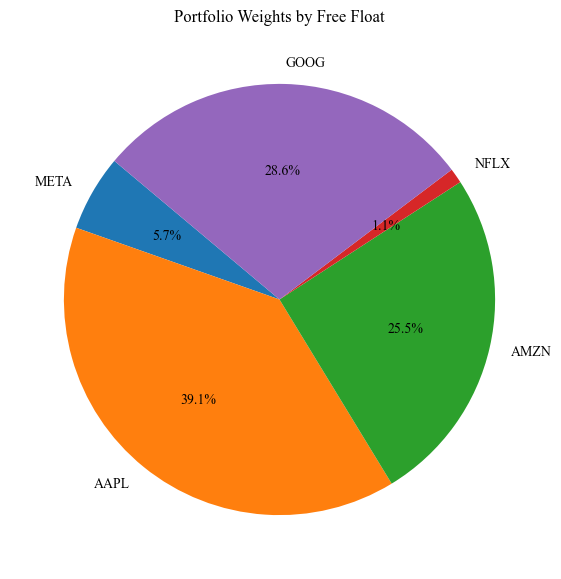

In [18]:
import matplotlib.pyplot as plt
from portfolio.free_float import build_portfolio_from_free_float
#FAANG
tickers = ["META", "AAPL", "AMZN", "NFLX", "GOOG"]

# Build weights and portfolio
df_w, df_p = build_portfolio_from_free_float(
    tickers,
    start="2024-01-01",
    end="2025-01-01",
    initial_investment=1000.0
)


weights = df_w.set_index("Ticker")["Free Float Weight"].dropna()

plt.figure(figsize=(7,7))
plt.pie(weights, labels=weights.index, autopct="%1.1f%%", startangle=140)
plt.title("Portfolio Weights by Free Float")
plt.show()

### 2. Calculating Portfolio Value
- For each day $t$, we calculate the **percentage change** (daily return) of each stock:
  $
  r_{i,t} = \frac{P_{i,t} - P_{i,t-1}}{P_{i,t-1}}
  $
  where $P_{i,t}$ is the closing price of stock $i$ at time $t$.

- The **portfolio return** on day $t$ is the weighted sum of individual returns:
  $
  R_t = \sum_i w_i \cdot r_{i,t}
  $

- Starting from an initial investment $V_0$ (e.g., \$1000),  
  the portfolio value updates each day via compounding:
  $
  V_t = V_{t-1} \times (1 + R_t)
  $

---

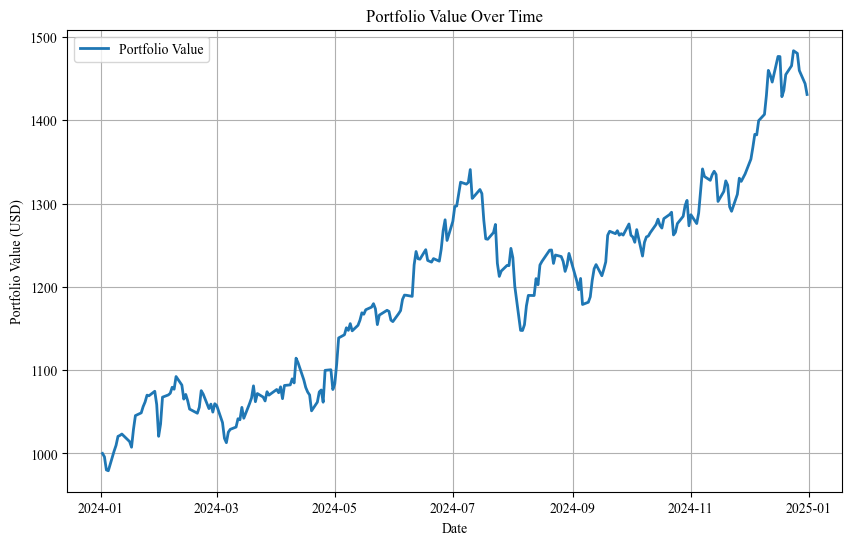

In [19]:
# Plot portfolio value vs time
plt.figure(figsize=(10, 6))
plt.plot(df_p.index, df_p["Portfolio Value"], label="Portfolio Value", linewidth=2)
plt.title("Portfolio Value Over Time")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (USD)")
plt.grid(True)
plt.legend()
plt.show()


## Portfolio vs. Single Stock Comparison

In the chart, we overlay the **portfolio value** against **Apple’s (AAPL) price performance**, both normalized to start at the same initial value (e.g., $1000).  

### What we see
- **Portfolio smoothing effect**:  
  The portfolio curve is generally smoother than the AAPL line. This is because portfolio returns are an average across multiple stocks, reducing the impact of sharp swings in any one ticker.  

- **Outperformance vs. underperformance**:  
  - If AAPL strongly outperforms the group, its line will rise faster than the portfolio.  
  - If AAPL underperforms, the portfolio will look stronger in comparison, showing the **diversification benefit**.  

- **Tracking behavior**:  
  Since AAPL typically has a large free float, it may carry significant weight in the portfolio. Thus, movements in the portfolio will still correlate strongly with AAPL, but they are not identical.  

### Key takeaway
The overlay highlights the **trade-off between concentration and diversification**:  
- Holding only AAPL gives higher upside potential but also higher volatility.  
- Holding the free-float-weighted portfolio reduces exposure to a single stock’s risk, creating a more stable growth trajectory.


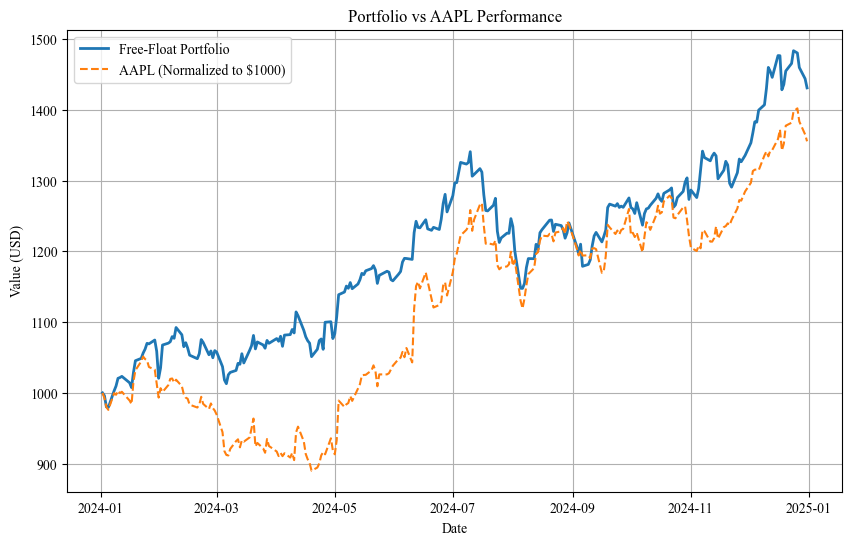

In [20]:

#Get AAPL prices (same date range)
aapl_prices = load_prices(["AAPL"], start="2024-01-01", end="2025-01-01", auto_adjust=True)

# Normalize AAPL price series to start at 1000 like the portfolio
aapl_normalized = aapl_prices["AAPL"] / aapl_prices["AAPL"].iloc[0] * 1000

# Plot comparison
plt.figure(figsize=(10, 6))
plt.plot(df_p.index, df_p["Portfolio Value"], label="Free-Float Portfolio", linewidth=2)
plt.plot(aapl_normalized.index, aapl_normalized, label="AAPL (Normalized to $1000)", linestyle="--")
plt.title("Portfolio vs AAPL Performance")
plt.xlabel("Date")
plt.ylabel("Value (USD)")
plt.grid(True)
plt.legend()
plt.show()


##  Correlation matrix of returns

We compute the **daily return correlations** among tickers and with the portfolio to understand co-movement.


In [ ]:
from data.analytics import calculate_correlations
import pandas as pd
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

# Date range for fetching data
start = "2024-01-01"
end   = "2025-01-01"

# Load prices (tickers must be defined; e.g., ["META","AAPL","AMZN","NFLX","GOOG"])
prices = load_prices(tickers, start=start, end=end, auto_adjust=True)
# Use your helper to compute the correlation matrix (includes Portfolio if passed)
corr = calculate_correlations(prices, df_portfolio=df_p)

print("== Correlation Matrix ==")
display(corr)


== Correlation Matrix ==


AAPL   AMZN   GOOG   META   NFLX  Portfolio
AAPL      1.0000 0.3373 0.3623 0.2263 0.2866     0.7379
AMZN      0.3373 1.0000 0.5339 0.5792 0.3973     0.7917
GOOG      0.3623 0.5339 1.0000 0.3822 0.3038     0.7989
META      0.2263 0.5792 0.3822 1.0000 0.3239     0.5729
NFLX      0.2866 0.3973 0.3038 0.3239 1.0000     0.4426
Portfolio 0.7379 0.7917 0.7989 0.5729 0.4426     1.0000

## Correlation heatmap

A quick visual of the correlation structure. Brighter cells ~ higher correlation.


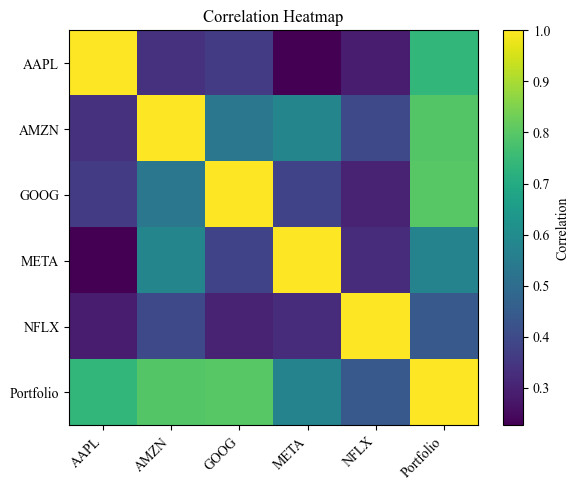

In [22]:
plt.figure(figsize=(6, 5))
plt.imshow(corr, aspect="auto")
plt.colorbar(label="Correlation")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


## Animated Rolling Correlation Heatmap

This animation shows how the **pairwise correlations** between tickers evolve over time using a rolling window.

- **Window (`window`)**: number of trading days per correlation estimate (e.g., 60).
- **Color scale**: fixed to \([-1, 1]\) so colors are comparable across frames.
- **One plot per figure**: a single heatmap that updates each frame.

**Steps**
1. Load prices and compute **daily returns**.
2. Compute a **rolling correlation matrix** for each window.
3. Animate the heatmap over time.

Tip: Larger windows → smoother but less reactive. Smaller windows → noisier but more responsive.


In [23]:
from matplotlib import animation

from data.fetch_data import load_prices
from matplotlib import rc
rc('animation', html='jshtml')  # tell matplotlib to render as JS/HTML
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib import animation
from data.analytics import calculate_correlations 

rc("animation", html="jshtml")  # render as JS/HTML in VS Code/Jupyter

# ---- Config ----
tickers = ["META", "AAPL", "AMZN", "NFLX", "GOOG"]
start = "2024-01-01"
end   = "2025-01-01"
window = 60           # rolling window length in trading days
interval_ms = 150     # animation speed (milliseconds between frames)

# ---- Data: prices -> returns handled INSIDE your helper ----
prices = load_prices(tickers, start=start, end=end, auto_adjust=True)



# Ensure we have enough rows for the first window
if len(prices) < window:
    raise ValueError(f"Not enough rows ({len(prices)}) for window={window}.")

# ---- Precompute rolling correlation matrices USING YOUR HELPER ----
dates = prices.index[window-1:]   # label each frame by the end-date of its window
corr_stack = []                   # list of (n x n) correlation matrices
cols = list(prices.columns)       # default labels (tickers); may expand if df_p is used

for i in range(window - 1, len(prices)):
    # Slice window [i-window+1, i]
    p_win = prices.iloc[i - window + 1 : i + 1]

    # Compute correlation via your helper.
    # If including portfolio correlation, use: C_df = calculate_correlations(p_win, df_portfolio=df_p)
    C_df = calculate_correlations(p_win)  
    # Capture columns on first iteration (in case helper adds "Portfolio")
    if i == window - 1:
        cols = list(C_df.columns)

    corr_stack.append(C_df.values)

corr_stack = np.stack(corr_stack, axis=0)  # shape: (T_frames, n, n)
n = len(cols)


# ---- Build animation ----
fig, ax = plt.subplots(figsize=(6.5, 5.5))
im = ax.imshow(corr_stack[0], vmin=-1, vmax=1, aspect="auto")
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Correlation", rotation=90)

# Ticks & labels
ax.set_xticks(range(n))
ax.set_yticks(range(n))
ax.set_xticklabels(cols, rotation=45, ha="right")
ax.set_yticklabels(cols)
title = ax.set_title(f"Rolling {window}-Day Correlation — {dates[0].date()}")

plt.tight_layout()

def init():
    im.set_data(corr_stack[0])
    title.set_text(f"Rolling {window}-Day Correlation — {dates[0].date()}")
    return (im, title)

def update(frame_idx):
    im.set_data(corr_stack[frame_idx])
    title.set_text(f"Rolling {window}-Day Correlation — {dates[frame_idx].date()}")
    return (im, title)

anim = animation.FuncAnimation(
    fig,
    update,
    init_func=init,
    frames=len(dates),
    interval=interval_ms,
    blit=True
)

# --- Display in Jupyter ---
import matplotlib.pyplot as plt
from IPython.display import display
plt.close(fig)   # avoid duplicate static image
display(anim)    # embedded, playable animation
